# Coordinate descent

In [1]:
protein = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1, 0],  # activities
    [1, 1, 0],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    protein,
    n_start=1,
    n_generate=100,
    endo_or_exo_probability=[0.9, 0.1],
    enzymes=enzymes,
)

 99 / 100 (266)
78 unique peptides. 101 total


## Coordinate descent



```py

G = #graph with weights

#Sort weights so that we start from the outgoing weights from largest nodes ("to the left").

for i in range(n_iterations): 
    for w in weights:   
        grad = compute_dL_dw() # compute gradient dependent on w
        w = w - grad * lr * k #update weight, make sure that sum(weights from outgoing node) < 1
        

        
```



# Re-paramterization

We parameterize

$w(\theta)$ where $\theta$ is constant for amino-acids and exoprotease

theta = {"A":a, "B": b ..., "exo":exo} where "A" and "B" are p1-amino-acids.



In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
from disassembly.util import KL, amino_acids


class WeightEstimatorGD:
    """
    Class to estimate weights using gradient descent.

    ```
    wegd = WeightEstimatorGD(lr, n_iterations, lam)
    generated_graph = wegd(true_dict, verbose=True)
    ```
    """

    def __init__(
        self,
        lr: float,
        n_iterations: int,
        lam: float,
    ) -> None:
        self.lr = lr
        self.n_iterations = n_iterations
        self.lam = lam

    def run(self, true_dict: dict, verbose: bool):
        exo = 0.1
        self.parameters = {
            "endo": {
                aa: 1 / (len(amino_acids.values()) + exo) for aa in amino_acids.values()
            },
            "exo": exo,
            "stop": 0.25,
        }  # endo is dict of aa at p1

        self.true_dict = true_dict
        self.keys = list(true_dict.keys())
        self.true_dict_vals = list(true_dict.values())
        self.graph = self.create_graph()  # creates the graph from keys

        self.generated = {}
        self.losses = []
        self.weights = {}

        for iteration in range(self.n_iterations):
            guess, guess_df = self.generate_output(self.graph)
            self.generated[iteration] = guess
            self.weights[iteration] = np.array(
                [data["weight"] for _, _, data in self.graph.edges(data=True)]
            )
            # Compute loss
            kl = KL(self.true_dict_vals, guess.values())
            reg = get_l2(self.graph) * self.lam
            loss = kl + reg
            self.losses.append(loss)

            if verbose:
                print(
                    f"\r {iteration} / {self.n_iterations} | {loss:.2f}, kl: {kl:.2f}, reg: {reg:.2f}  | nz: { np.sum( self.weights[iteration] > 0.01 )} | ",
                    end="",
                    flush=True,
                )

            # Compute gradient
            dp_dw = self.compute_dp_dw(guess_df)
            dL_dp = self.compute_dL_dp(self.true_dict_vals, list(guess.values()))
            gradient = self.compute_dL_dw(dL_dp, dp_dw)
            grad_reg = self.get_grad_reg_l2(self.graph)

            # Update graph
            self.graph = self.update_weights(gradient, grad_reg)

            if loss < 0.01:
                break

        return self.graph

    def generate_output(self, graph: nx.DiGraph) -> (dict, pd.DataFrame):
        """
        Generates an output dict from a graph
        """
        longest_key = sorted(self.keys, key=len)[-1]
        p_generated = {}
        terminal_nodes = [node for node in graph.nodes() if graph.out_degree(node) == 0]

        for node in terminal_nodes:  # one hot terminal nodes
            oh_node = create_one_hot(self.keys, node)
            p_generated[node] = oh_node

        out_edges = {
            source: [
                target for _, target in graph.out_edges(source) if source != target
            ]
            for source in graph.nodes()
        }

        while len(p_generated.keys()) < len(self.keys):
            solvables = get_solvable(out_edges, p_generated)
            for solvable in solvables:
                p_generated[solvable] = np.zeros(len(self.keys))

                for source, target in graph.out_edges(solvable):
                    p_target = p_generated[target]
                    w_source_target = graph[source][target]["weight"]
                    p_generated[source] += w_source_target * p_target

                w_source_target = 1 - sum(
                    [
                        data["weight"]
                        for _, _, data in graph.out_edges(source, data=True)
                    ]
                )
                p_target = create_one_hot(self.keys, source)
                p_generated[source] += w_source_target * p_target

        guess = {
            self.keys[i]: p_generated[longest_key][i] for i in range(len(self.keys))
        }
        return guess, pd.DataFrame(p_generated, index=self.keys)

    def create_graph(self):
        """
        Each edge has a weight, a type and a p1_left and p1_right

        p1_left exists if there has been a cut on the left of the generated peptide
        p1_right ---ll---

        type is endo or exo

        """
        graph = nx.DiGraph()
        graph.add_nodes_from([(k, {"layer": len(k)}) for k in self.keys])
        for key1 in self.keys:
            for key2 in self.keys:
                if (key1 in key2) and (key1 != key2):
                    if len(key1) == len(key2) - 1:
                        endo_or_exo = "exo"
                        p1_left = None
                        p1_right = None
                        w = self.parameters["exo"]
                    elif key2.startswith(key1):
                        endo_or_exo = "endo"
                        p1_left = None
                        p1_right = key1[-1]
                        w = self.parameters["endo"][p1_right]
                    elif key2.endswith(key1):
                        endo_or_exo = "endo"
                        p1_left = key2[-len(key1) - 1]
                        p1_right = None
                        w = self.parameters["endo"][p1_left]
                    else:  # middle
                        endo_or_exo = "endo"
                        p1_left = key2[key2.find(key1) - 1]
                        p1_right = key1[-1]
                        w = (
                            self.parameters["endo"][p1_left]
                            * self.parameters["endo"][p1_right]
                        )

                    graph.add_edge(
                        key2,
                        key1,
                        weight=w,
                        type=endo_or_exo,
                        p1_left=p1_left,
                        p1_right=p1_right,
                    )

        return graph

    def update_weights_w_parameters(self):
        """

        Updates the graph weights based on self.parameters

        """
        new_graph = self.graph.copy()

        for source, target, data in new_graph.edges(data=True):
            if data["type"] == "exo":
                w = self.parameters["exo"]
            elif data["type"] == "endo":
                if data["p1_left"] is None:
                    w = self.parameters["endo"][data["p1_right"]]
                elif data["p1_right"] is None:
                    w = self.parameters["endo"][data["p1_left"]]
                else:
                    w = (
                        self.parameters["endo"][data["p1_left"]]
                        * self.parameters["endo"][data["p1_right"]]
                    )
            nx.set_edge_attributes(
                new_graph,
                {(source, target): {"weight": w}},
            )
        return new_graph

    def compute_dp_dw(self, guess_df: pd.DataFrame) -> dict:
        """
        dP / dw
        Change of P based on w
        Sx1 vector
        """
        longest_key = sorted(self.keys, key=len)[-1]
        prob_traversed = {key: 0 for key in self.keys}
        prob_traversed[longest_key] = 1

        for sequence, n in prob_traversed.items():
            out_edges = [
                (source, target, data)
                for source, target, data in self.graph.out_edges(sequence, data=True)
            ]
            weights = np.array([weight["weight"] for _, _, weight in out_edges])
            edges_to = [edge_to for _, edge_to, _ in out_edges]
            for w, e in zip(weights, edges_to):
                prob_traversed[e] += w * n

        dp_dw = {}

        for key in self.keys:
            out_edges = self.graph.out_edges(key)
            for (
                source,
                target,
            ) in out_edges:  # P(longest to source) * (P(target) - onehot(source))
                dp_dw[(source, target)] = prob_traversed[source] * (
                    guess_df[target].values - create_one_hot(self.keys, source)
                )

        return dp_dw

    def update_weights(self, grad, grad_reg=None) -> nx.DiGraph:
        diffs = {}
        k = 1

        old_graph = nx.DiGraph()
        for source, target, data in self.graph.edges(data=True):
            old_graph.add_edge(source, target, weight=data["weight"])

        old_loss = self.losses[-1]

        for source in self.graph.nodes():
            sum_old_weight = sum(
                [
                    data["weight"]
                    for _, _, data in self.graph.out_edges(source, data=True)
                ]
            )
            sum_diffs = 0

            for source, target in self.graph.out_edges(source):
                old_weight = self.graph[source][target]["weight"]
                grad_weight = grad[(source, target)]

                if grad_reg:  # if we regularize
                    grad_weight += grad_reg[(source, target)]

                new_weight = max(0, old_weight - self.lr * grad_weight)
                diff = new_weight - old_weight  # diff is -lr*grad
                sum_diffs += diff
                diffs[(source, target)] = diff

            while (sum_old_weight + k * sum_diffs) >= 1:
                k = k / 2

        new_graph = self.graph.copy()

        while True:
            # Update graph
            for source, target in new_graph.edges():
                nx.set_edge_attributes(
                    new_graph,
                    {
                        (source, target): {
                            "weight": max(
                                0,
                                old_graph[source][target]["weight"]
                                + diffs[(source, target)] * k,
                            )
                        }
                    },
                )

            # Get new KL
            new_guess, _ = self.generate_output(new_graph)

            new_loss = KL(self.true_dict_vals, list(new_guess.values())) + (
                get_l2(new_graph) * self.lam
            )

            if new_loss <= old_loss:
                return new_graph

            if k < 1e-15:
                return old_graph

            k = k / 2
            new_graph = self.graph  # resets the new_graph to graph

    def update_parameters(self, dL_dtheta):
        """

        Update the parameters with dL_dtheta


        """

        pass

    def compute_dL_dp(self, true, guess):
        return -np.array(true) / (np.array(guess) + 1e-8)

    def compute_dL_dw(self, dL_dp, dp_dw):
        """
        Gradient
        """
        dL_dw = {}
        for edge, val in dp_dw.items():
            dL_dw[edge] = np.sum(val * dL_dp)
        return dL_dw

    def get_grad_reg_l2(self, graph):
        grad_reg = {}
        for source in graph.nodes():
            for _, target, data in graph.out_edges(source, data=True):
                grad_reg[(source, target)] = 2 * data["weight"] * self.lam  # + self.lam
        return grad_reg

    def drop_weights(self, threshold: float = 0.01):
        """
        Idea, drop edges that are very small
        """
        new_graph = nx.DiGraph()
        for source, target, data in self.graph.edges(data=True):
            if data["weight"] > threshold:
                new_graph.add_edge(source, target, weight=data["weight"])
        return new_graph

    def dw_dtheta(self):
        "gradient of theta"
        dw_dtheta = {
            "endo": 1 - self.parameters["stop"],
            "exo": 1 - self.parameters["stop"],
            "stop": 0,
        }
        return dw_dtheta

    def compute_dL_dtheta(self, dL_dw, dw_dtheta):
        """
        dL/dtheta = dL/dw * dw/dtheta
        """
        dL_dtheta = {}
        for edge, val in dL_dw.items():
            data = self.graph[edge]
            dL_dtheta[edge] = val * dw_dtheta[data["type"]]  # 1x1 * 1x1

        return dL_dtheta


def create_one_hot(keys, key):
    one_hot = np.zeros(len(keys))
    one_hot[keys.index(key)] = 1
    return one_hot


def get_solvable(out_edges, p_generated):
    solvable = []
    for source, targets in out_edges.items():
        if (
            set(targets).issubset(set((p_generated.keys())))
            and source not in p_generated.keys()
        ):
            solvable.append(source)
    return solvable


def get_l1(graph):
    return sum([abs(data["weight"]) for _, _, data in graph.edges(data=True)])


def get_l2(graph):
    return sum([data["weight"] ** 2 for _, _, data in graph.edges(data=True)])


def get_elastic_net(graph, lambda_1, lambda_2):
    return sum(
        [
            (lambda_1 * abs(data["weight"]))  # L1
            + (lambda_2 * data["weight"] ** 2)  # L2
            for _, _, data in graph.edges(data=True)
        ]
    )

# Monte Carlo estimate of parameters

1. Simulate distribution with parameters
2. Calc KL.
3. Update parameters numerically

Repeat until convergence

In [2]:
from disassembly.util import amino_acids

exo = 0.25
parameters = {
    "endo": {aa: 1 / (len(amino_acids.values())) for aa in amino_acids.values()},
    "exo": exo,
    "stop": 0.5,
}  # endo is dict of aa at p1
parameters

{'endo': {'V': 0.05,
  'I': 0.05,
  'L': 0.05,
  'E': 0.05,
  'Q': 0.05,
  'D': 0.05,
  'N': 0.05,
  'H': 0.05,
  'W': 0.05,
  'F': 0.05,
  'Y': 0.05,
  'R': 0.05,
  'K': 0.05,
  'S': 0.05,
  'T': 0.05,
  'M': 0.05,
  'A': 0.05,
  'G': 0.05,
  'P': 0.05,
  'C': 0.05},
 'exo': 0.25,
 'stop': 0.5}

In [2]:
protein = "MAHVRGLRSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 0, 0],  # activities
    [1, 0, 0],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    protein,
    n_start=1,
    n_generate=100,
    endo_or_exo_probability=[.9999,.0001],
    enzymes=enzymes,
)
dict(sorted(P.items(), key=lambda item: item[1], reverse=True))

 99 / 100 (6269)
4 unique peptides. 101 total


{'AHVRGLRSLLQRVHSGLQLPK': 80,
 'AHVRGLRSLLQRVHSGLQLPKGQHVFLAK': 19,
 'MAHVRGLRSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV': 1,
 'AHVRGLRSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV': 1}

In [10]:
# Simulate P with MC and parameters


def find_aminoacids_in_sequence(protein_sequence, target_aminoacid):
    indexes = [i for i, aa in enumerate(protein_sequence) if aa == target_aminoacid]
    if len(protein_sequence) - 1 in indexes:
        indexes.remove(len(protein_sequence) - 1)
    return indexes


import numpy as np

def generate_guess(parameters, protein):
        
    n_exo = 0
    n_endo = 0
    n_particles = 100
    generated = {}
    for _ in range(n_particles):
        sequence = protein
        while True:
            exo_endo_or_stop = np.random.choice(
                ["exo", "endo", "stop"],
                p=[
                    parameters["exo"],
                    (1 - (parameters["exo"] + parameters["stop"])),
                    parameters["stop"],
                ],
            )
            if (exo_endo_or_stop == "stop" or len(sequence) < 5) and sequence != protein:
                if sequence in generated:
                    generated[sequence] += 1
                else:
                    generated[sequence] = 1
                break
            elif exo_endo_or_stop == "exo":
                n_exo += 1
                u = np.random.uniform(0, 1)
                if u < 0.5:
                    sequence = sequence[1:]
                else:
                    sequence = sequence[:-1]
            else: 
                try: # endo
                    n_endo += 1

                    index_to_cut = {}
                    for aminoacid in parameters["endo"].keys():
                        indices_for_aminoacid = find_aminoacids_in_sequence(sequence, aminoacid)
                        for index in indices_for_aminoacid:
                            if index != len(sequence):
                                index_to_cut[index] = parameters["endo"][aminoacid]
                    cutting_index = int(
                        np.random.choice(
                            list(index_to_cut.keys()),
                            p=[p / sum(index_to_cut.values()) for p in index_to_cut.values()],
                        )
                    )
                    u = np.random.uniform(0, 1)
                    if u < 0.5 and len(sequence[:cutting_index]) > 5:
    
                        sequence = sequence[:cutting_index+1]
                    else:
                        sequence = sequence[cutting_index+1:]
                except:
                    continue
    return dict(sorted(generated.items(), key=lambda item: item[1], reverse=True))

generated = generate_guess(parameters, protein)
generated

{'AHVRGLQLPKGCLALAALCSLVHSQHVFLAKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV': 9,
 'MAHVRGLQLPKGCLALAALCSLVHSQHVFLAKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQR': 8,
 'VHSQHVFLAKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV': 2,
 'CLALAALCSLVHSQHVFLAKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQR': 2,
 'AHVRGLQLPKGCLALAA': 2,
 'SLLQRV': 2,
 'GLQLPKGQHVFLAKPQQARSLLQRV': 2,
 'QRV': 2,
 'KPQQARSLLQRV': 2,
 'HVRGLQLPKGCLALAALCSLVHSQHVFLAKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV': 2,
 'MAHVRGLQLPKGCLALAALCSLVHSQHVFLAKPQQARSL': 2,
 'MAHVRGLQLPKGCLALAALCSLVH': 2,
 'FLAKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQR': 1,
 'CLALAALCSLVHSQHVFLAKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV': 1,
 'AKPQQARSLLQRV': 1,
 'SQHVFLAKP': 1,
 'VRGLQLPKGCLALAALCSLVHSQHVFLAKPQQA': 1,
 'LLQRVHSGLQL': 1,
 'HVRGLQLPKGCLALAALCSLVHSQHVFLAKPQQARSLLQRVHSGL': 1,
 'AKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV': 1,
 'MAHVRGLQLPKGCLALAA': 1,
 'VFLAKPQQARSLLQRVHSGLQLPKGQHVFLAKPQQARSLLQRV': 1,
 'HVRGLQLPKGCLALAA': 1,
 'ALAALCSLVHSQHVFLAKPQQARSLLQRVHSGLQLPKGQHVFLAK': 1,

In [11]:
from disassembly.util import KL, normalize_dict

def compare(P, generated):
    P = normalize_dict(P)
    generated = normalize_dict(generated)
    P_vec = []
    generated_vec = []
    for key in P.keys():
        P_vec.append(P[key])
        if key in generated.keys():
            generated_vec.append(generated[key])
        else:
            generated_vec.append(0)
    for key in generated.keys():
        if key not in P.keys():
            P_vec.append(0)
            generated_vec.append(generated[key])
    return P_vec, generated_vec


generated = generate_guess(parameters, protein)
p, q = compare(P, generated)
KL(p,q)




16.23842660355932

In [14]:
# update parameters

import copy

# update endo

# update exo and stop

lr = 1e-2

losses = []
loss_to_beat = KL(p,q)

for i in range(10):
    print(f"\r {i}", end="", flush=True)
    for aa in parameters["endo"].keys():
        for i in range(10):
            e = np.random.choice([lr, -lr])
            parameters["endo"][aa] += e
            new_guess = generate_guess(parameters, protein)
            p,q = compare(P, new_guess)
            new_loss = KL(p,q)
            if new_loss > loss_to_beat:
                parameters["endo"][aa] -= e
            else:
                print(f"endo {aa} {new_loss}")
                loss_to_beat = new_loss
                losses.append(new_loss)

    
    for param in ["stop","exo"]:
        e = np.random.choice([lr, -lr])
        parameters[param] += e
        new_guess = generate_guess(parameters, protein)
        p,q = compare(P, new_guess)
        new_loss = KL(p,q)
        if new_loss > loss_to_beat:
            parameters[param] -= e
        else:
            loss_to_beat = new_loss
            losses.append(new_loss)
            print(f"{param} {new_loss}")
        
parameters

 0endo V 16.23842671163291
endo V 16.238425527867484
endo V 16.23842552316745
endo L 15.14412880228282
endo H 11.587660083519324
 2endo V 11.587659800641305
 3endo N 11.450873492798436
 9

{'endo': {'V': 0.019999999999999997,
  'I': 0.05,
  'L': 0.060000000000000005,
  'E': 0.03,
  'Q': 0.05,
  'D': 0.04,
  'N': 0.060000000000000005,
  'H': 0.04,
  'W': 0.05,
  'F': 0.05,
  'Y': 0.05,
  'R': 0.04,
  'K': 0.05,
  'S': 0.05,
  'T': 0.05,
  'M': 0.05,
  'A': 0.05,
  'G': 0.05,
  'P': 0.05,
  'C': 0.060000000000000005},
 'exo': 0.25,
 'stop': 0.5}

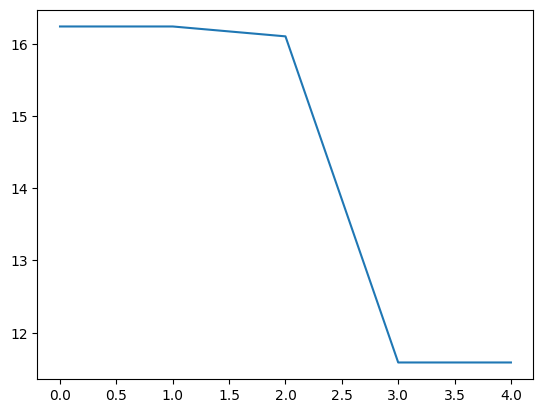

In [13]:
import matplotlib.pyplot as plt

plt.plot(losses)